In [ ]:
! pip install gpytorch
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import tqdm
from torch.optim.lr_scheduler import MultiStepLR
import gpytorch
import math
import numpy as np
import os
from PIL import Image

     |████████████████████████████████| 245kB 4.3MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.1.1-py2.py3-none-any.whl size=400467 sha256=62a9846868dbf67ecedb061c0740c5e611a9406d57f8e90233a09a06a3c36342
  Stored in directory: /root/.cache/pip/wheels/e5/a5/29/4dafc0624adf678108e0067836556f0c72588e85d851d78ae0
Successfully built gpytorch


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
% cd /content/drive/My Drive/Colab Notebooks/UCMerced_LandUse
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
args = {'log_interval': 1, 'learning_rate': 1e-3, 'step_size': 75, 'gamma': 0.1, 'n_epochs': 50, 'batch_size_train': 128, 'batch_size_test': 64}
torch.manual_seed(1)
print(use_cuda)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/UCMerced_LandUse
True


In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, mode, split, noise=False):
    path = './Images/'
    self.noise = noise
    categories = os.listdir(path)
    imgs = []
    target = []
    for category_idx in (range(len(categories))):
      img_categories = os.listdir(path + categories[category_idx])
      for img_idx in (range(len(img_categories))):
        im_path = path + categories[category_idx] + '/' + img_categories[img_idx]
        imgs.append(im_path)
        target.append(category_idx)
    self.imgs = np.array(imgs)
    self.target = np.array(target)
    self.img_exceptions = [130, 183, 209, 243, 396, 504, 505, 506, 507, 622, 623, 624, 633, 
                           770, 788, 858, 861, 863, 864, 865, 866, 867, 868, 869, 870, 915, 
                           935, 945, 993, 1055, 1060, 1077, 1122, 1145, 1146, 1308, 1320, 
                           1699, 1714, 1736, 1857, 2060, 2062, 2063]
    self.img_idxs = []
    for idx in range(len(imgs)):
      if idx not in self.img_exceptions:
        self.img_idxs.append(idx)

    self.img_idxs = np.array(self.img_idxs)
    np.random.shuffle(self.img_idxs)

    self.imgs = self.imgs[self.img_idxs]
    self.target = self.target[self.img_idxs]
    self.num_classes = max(self.target)
    self.categories = categories

    split_idx = int(len(self.imgs) * split)
    if mode == 'train':
        self.imgs = self.imgs[:split_idx]
        self.target = self.target[:split_idx]
    elif mode == 'test':
        self.imgs = self.imgs[split_idx:]
        self.target = self.target[split_idx:]

  def __len__(self):
    return len(self.imgs)
  
  def __getitem__(self, index):
    idx = index
    
    im_path = self.imgs[idx]
    im = Image.open(im_path)
    im = np.array(im)
    if self.noise:
        pois = 50
        im = np.random.poisson(im / 255. * pois) / pois * 255

    im = im / 255.
    
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    means = [0.5, 0.5, 0.5]
    stds = [0.5, 0.5, 0.5]

    for ch in range(3):
        im[:,:,ch] = (im[:,:,ch] - means[ch]) / stds[ch]

    return im.reshape((3,256,256)), self.target[idx]

In [ ]:
train_dataset = Dataset('train', 0.7)
test_dataset = Dataset('test', 0.7)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = True)


In [ ]:
test_dataset_noise = Dataset('test', 0.7, noise = True)
test_loader_noise = torch.utils.data.DataLoader(test_dataset_noise, shuffle = True)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_features)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 59536)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class GaussianProcessLayer(gpytorch.models.ApproximateGP):
    def __init__(self, num_dim, grid_bounds=(-10., 10.), grid_size=64):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=grid_size, batch_shape=torch.Size([num_dim])
        )
        variational_strategy = gpytorch.variational.MultitaskVariationalStrategy(
            gpytorch.variational.GridInterpolationVariationalStrategy(
                self, grid_size=grid_size, grid_bounds=[grid_bounds],
                variational_distribution=variational_distribution,
            ), num_tasks=num_dim,
        )
        super().__init__(variational_strategy)
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = gpytorch.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

class DKLModel(gpytorch.Module):
    def __init__(self, feature_extractor, num_dim, likelihood, grid_bounds=(-10., 10.)):
        super(DKLModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim
        self.likelihood = likelihood
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        features = self.feature_extractor(x)
        features = gpytorch.utils.grid.scale_to_bounds(features, self.grid_bounds[0], self.grid_bounds[1])
        features = features.transpose(-1, -2).unsqueeze(-1)
        res_gp = self.gp_layer(features)
        return res_gp

def train(args, model, likelihood, mll, device, train_loader, optimizer, epoch):
    model.train()
    likelihood.train()

    total_loss = 0
    loss_fn = nn.NLLLoss()

    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc=f"(Epoch {epoch}) Minibatch")
    with gpytorch.settings.num_likelihood_samples(8):
      for data, target in minibatch_iter:
          data = data.to(device).float()
          target = target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = -mll(output, target)
          total_loss += loss.item()
          loss.backward()
          optimizer.step()
          minibatch_iter.set_postfix(loss=loss.item())
    total_loss /= len(train_loader.dataset)
    return total_loss

def test(model, likelihood, mll, device, test_loader, epoch):
    model.eval()
    likelihood.eval()
    test_loss = 0
    correct = 0
    minibatch_iter = tqdm.notebook.tqdm(test_loader, desc=f"(Epoch {epoch}) Minibatch")
    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
        for data, target in minibatch_iter:
            data = data.to(device).float()
            target = target.to(device)
            output = model(data)
            loss = -mll(output, target)
            test_loss += loss.item()
            pred = likelihood(output).probs.mean(0).argmax(-1)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    return test_loss, correct / len(test_loader.dataset)

In [ ]:
num_dim = 100
num_classes = train_loader.dataset.num_classes
#resnet18 = models.resnet18(pretrained=True)
#NN = resnet18
NN = CNN(num_dim)
likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=num_dim, num_classes=num_classes)
model = DKLModel(NN, num_dim, likelihood)

model = model.to(device)
likelihood = likelihood.to(device)

learnable_params = [
    { 'params': model.feature_extractor.parameters(), 'weight_decay': 1e-6},
    {'params': model.gp_layer.hyperparameters(), 'lr': args['learning_rate'] * 0.01},
    {'params': model.gp_layer.variational_parameters()},
    {'params': model.likelihood.parameters()},
]

optimizer = SGD(learnable_params, lr=args['learning_rate'], momentum=0.9, nesterov=True, weight_decay=0)
scheduler = StepLR(optimizer, step_size=args['step_size'], gamma=args['gamma'])

mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model.gp_layer, len(train_loader))
print(num_classes)

20


In [ ]:
for epoch in range(1, args['n_epochs'] + 1):
  train_loss = train(args, model, likelihood, mll, device, train_loader, optimizer, epoch)
  test_loss, acc = test(model, likelihood, mll, device, test_loader, epoch)
  test_loss_noise, acc_noise = test(model, likelihood, mll, device, test_loader_noise, epoch)
  print('\n==> Epoch: {}, Train Loss: {:.4e}, Test Loss: {:.4e}, Test Acc: {:.4e}, Test Loss Noise: {:.4e}, Test Acc Noise: {:.4e}'.format(epoch, train_loss, test_loss, acc, test_loss_noise, acc_noise))
  scheduler.step()



==> Epoch: 1, Train Loss: 2.7271e+00, Test Loss: 2.7342e+00, Test Acc: 4.7002e-02, Test Loss Noise: 2.8223e+00, Test Acc Noise: 2.9173e-02




==> Epoch: 2, Train Loss: 2.6086e+00, Test Loss: 2.7765e+00, Test Acc: 4.3760e-02, Test Loss Noise: 2.7983e+00, Test Acc Noise: 2.9173e-02




==> Epoch: 3, Train Loss: 2.6211e+00, Test Loss: 2.8620e+00, Test Acc: 5.9968e-02, Test Loss Noise: 2.8113e+00, Test Acc Noise: 5.3485e-02




==> Epoch: 4, Train Loss: 2.5220e+00, Test Loss: 2.8408e+00, Test Acc: 6.6451e-02, Test Loss Noise: 2.6721e+00, Test Acc Noise: 5.6726e-02




==> Epoch: 5, Train Loss: 2.6701e+00, Test Loss: 2.7675e+00, Test Acc: 7.2934e-02, Test Loss Noise: 2.7711e+00, Test Acc Noise: 5.8347e-02




==> Epoch: 6, Train Loss: 2.5665e+00, Test Loss: 2.7596e+00, Test Acc: 8.4279e-02, Test Loss Noise: 2.7754e+00, Test Acc Noise: 9.2382e-02




==> Epoch: 7, Train Loss: 2.6766e+00, Test Loss: 2.7049e+00, Test Acc: 1.8152e-01, Test Loss Noise: 2.7486e+00, Test Acc Noise: 1.4749e-01




==> Epoch: 8, Train Loss: 2.4730e+00, Test Loss: 2.6910e+00, Test Acc: 1.9287e-01, Test Loss Noise: 2.5150e+00, Test Acc Noise: 1.7018e-01




==> Epoch: 9, Train Loss: 2.5880e+00, Test Loss: 2.7328e+00, Test Acc: 1.0373e-01, Test Loss Noise: 2.5860e+00, Test Acc Noise: 9.8865e-02




==> Epoch: 10, Train Loss: 2.4141e+00, Test Loss: 2.5153e+00, Test Acc: 1.9935e-01, Test Loss Noise: 2.4891e+00, Test Acc Noise: 2.0097e-01




==> Epoch: 11, Train Loss: 2.3770e+00, Test Loss: 2.5347e+00, Test Acc: 1.7342e-01, Test Loss Noise: 2.4772e+00, Test Acc Noise: 1.5883e-01




==> Epoch: 12, Train Loss: 2.2963e+00, Test Loss: 2.3300e+00, Test Acc: 1.9773e-01, Test Loss Noise: 2.3730e+00, Test Acc Noise: 1.7990e-01




==> Epoch: 13, Train Loss: 2.1644e+00, Test Loss: 2.2184e+00, Test Acc: 2.3501e-01, Test Loss Noise: 2.2214e+00, Test Acc Noise: 2.1070e-01




==> Epoch: 14, Train Loss: 2.0013e+00, Test Loss: 2.2591e+00, Test Acc: 1.9449e-01, Test Loss Noise: 2.1911e+00, Test Acc Noise: 2.0746e-01




==> Epoch: 15, Train Loss: 1.9786e+00, Test Loss: 1.9609e+00, Test Acc: 2.9660e-01, Test Loss Noise: 2.0391e+00, Test Acc Noise: 2.4311e-01




==> Epoch: 16, Train Loss: 1.9013e+00, Test Loss: 1.9211e+00, Test Acc: 3.6305e-01, Test Loss Noise: 1.9674e+00, Test Acc Noise: 2.7229e-01




==> Epoch: 17, Train Loss: 1.6731e+00, Test Loss: 1.7688e+00, Test Acc: 3.9870e-01, Test Loss Noise: 1.7324e+00, Test Acc Noise: 3.0308e-01




==> Epoch: 18, Train Loss: 1.4692e+00, Test Loss: 1.5772e+00, Test Acc: 4.6677e-01, Test Loss Noise: 1.7946e+00, Test Acc Noise: 4.1491e-01




==> Epoch: 19, Train Loss: 1.2967e+00, Test Loss: 1.5060e+00, Test Acc: 4.7650e-01, Test Loss Noise: 1.5532e+00, Test Acc Noise: 4.4246e-01




==> Epoch: 20, Train Loss: 1.0703e+00, Test Loss: 1.5024e+00, Test Acc: 5.5429e-01, Test Loss Noise: 1.7200e+00, Test Acc Noise: 4.7326e-01




==> Epoch: 21, Train Loss: 8.7156e-01, Test Loss: 1.4464e+00, Test Acc: 5.6888e-01, Test Loss Noise: 1.4512e+00, Test Acc Noise: 5.2836e-01




==> Epoch: 22, Train Loss: 5.7242e-01, Test Loss: 1.2631e+00, Test Acc: 6.8233e-01, Test Loss Noise: 1.3879e+00, Test Acc Noise: 6.4019e-01




==> Epoch: 23, Train Loss: 3.6372e-01, Test Loss: 1.1656e+00, Test Acc: 7.1151e-01, Test Loss Noise: 1.3510e+00, Test Acc Noise: 6.3857e-01




==> Epoch: 24, Train Loss: 1.1842e-01, Test Loss: 1.0832e+00, Test Acc: 7.4392e-01, Test Loss Noise: 1.2354e+00, Test Acc Noise: 6.7423e-01




==> Epoch: 25, Train Loss: 9.9701e-02, Test Loss: 1.1040e+00, Test Acc: 7.4230e-01, Test Loss Noise: 1.2659e+00, Test Acc Noise: 6.8720e-01




==> Epoch: 26, Train Loss: 6.0803e-02, Test Loss: 1.1106e+00, Test Acc: 7.2123e-01, Test Loss Noise: 1.2175e+00, Test Acc Noise: 6.9854e-01




==> Epoch: 27, Train Loss: -7.1455e-02, Test Loss: 1.0671e+00, Test Acc: 7.5041e-01, Test Loss Noise: 1.1725e+00, Test Acc Noise: 6.9854e-01




==> Epoch: 28, Train Loss: -1.4356e-01, Test Loss: 1.1927e+00, Test Acc: 7.3582e-01, Test Loss Noise: 1.3341e+00, Test Acc Noise: 6.9692e-01




==> Epoch: 29, Train Loss: -2.9603e-02, Test Loss: 1.1042e+00, Test Acc: 7.4878e-01, Test Loss Noise: 1.1669e+00, Test Acc Noise: 7.0178e-01




==> Epoch: 30, Train Loss: -1.5360e-01, Test Loss: 1.1863e+00, Test Acc: 7.5041e-01, Test Loss Noise: 1.1901e+00, Test Acc Noise: 7.0502e-01




==> Epoch: 31, Train Loss: -2.5875e-01, Test Loss: 1.1401e+00, Test Acc: 7.5365e-01, Test Loss Noise: 1.3334e+00, Test Acc Noise: 7.0340e-01




==> Epoch: 32, Train Loss: -2.7283e-01, Test Loss: 1.2390e+00, Test Acc: 7.4878e-01, Test Loss Noise: 1.3100e+00, Test Acc Noise: 7.1151e-01




==> Epoch: 33, Train Loss: -4.0605e-02, Test Loss: 1.1843e+00, Test Acc: 7.5527e-01, Test Loss Noise: 1.3211e+00, Test Acc Noise: 7.0178e-01




==> Epoch: 34, Train Loss: -1.3014e-01, Test Loss: 1.1578e+00, Test Acc: 7.4554e-01, Test Loss Noise: 1.2138e+00, Test Acc Noise: 7.1637e-01




==> Epoch: 35, Train Loss: -1.9201e-01, Test Loss: 1.1107e+00, Test Acc: 7.4878e-01, Test Loss Noise: 1.2861e+00, Test Acc Noise: 7.2123e-01




==> Epoch: 36, Train Loss: -1.2637e-01, Test Loss: 1.1868e+00, Test Acc: 7.4554e-01, Test Loss Noise: 1.3598e+00, Test Acc Noise: 7.0665e-01




==> Epoch: 37, Train Loss: -1.7620e-01, Test Loss: 1.0685e+00, Test Acc: 7.5041e-01, Test Loss Noise: 1.3909e+00, Test Acc Noise: 7.1475e-01




==> Epoch: 38, Train Loss: -1.4980e-01, Test Loss: 1.1003e+00, Test Acc: 7.5203e-01, Test Loss Noise: 1.3635e+00, Test Acc Noise: 7.0665e-01




==> Epoch: 39, Train Loss: -1.3500e-02, Test Loss: 1.1264e+00, Test Acc: 7.4878e-01, Test Loss Noise: 1.2855e+00, Test Acc Noise: 7.2285e-01




==> Epoch: 40, Train Loss: -1.1295e-01, Test Loss: 1.1856e+00, Test Acc: 7.4878e-01, Test Loss Noise: 1.2871e+00, Test Acc Noise: 7.2285e-01




==> Epoch: 41, Train Loss: -1.3396e-01, Test Loss: 1.2089e+00, Test Acc: 7.5365e-01, Test Loss Noise: 1.2626e+00, Test Acc Noise: 7.1151e-01




==> Epoch: 42, Train Loss: -3.8034e-01, Test Loss: 1.1041e+00, Test Acc: 7.5041e-01, Test Loss Noise: 1.3792e+00, Test Acc Noise: 7.0989e-01




==> Epoch: 43, Train Loss: -2.1521e-01, Test Loss: 1.0379e+00, Test Acc: 7.5527e-01, Test Loss Noise: 1.3408e+00, Test Acc Noise: 7.1637e-01




==> Epoch: 44, Train Loss: -9.9544e-02, Test Loss: 1.1567e+00, Test Acc: 7.4716e-01, Test Loss Noise: 1.2831e+00, Test Acc Noise: 7.0827e-01




==> Epoch: 45, Train Loss: -2.3496e-01, Test Loss: 1.1265e+00, Test Acc: 7.5365e-01, Test Loss Noise: 1.2024e+00, Test Acc Noise: 7.0989e-01




==> Epoch: 46, Train Loss: -2.2820e-01, Test Loss: 1.1350e+00, Test Acc: 7.5203e-01, Test Loss Noise: 1.2862e+00, Test Acc Noise: 7.0827e-01




==> Epoch: 47, Train Loss: -2.7369e-01, Test Loss: 1.2145e+00, Test Acc: 7.4878e-01, Test Loss Noise: 1.3074e+00, Test Acc Noise: 7.1475e-01




==> Epoch: 48, Train Loss: -1.8495e-01, Test Loss: 1.1872e+00, Test Acc: 7.4878e-01, Test Loss Noise: 1.3637e+00, Test Acc Noise: 7.1637e-01




==> Epoch: 49, Train Loss: -1.2402e-01, Test Loss: 1.1403e+00, Test Acc: 7.5365e-01, Test Loss Noise: 1.2071e+00, Test Acc Noise: 7.1151e-01




==> Epoch: 50, Train Loss: -1.3402e-01, Test Loss: 1.1838e+00, Test Acc: 7.5203e-01, Test Loss Noise: 1.2846e+00, Test Acc Noise: 7.0989e-01


Individual Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0


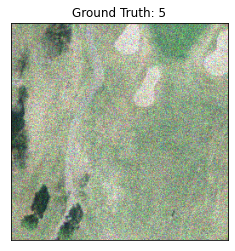

In [ ]:
model.eval()
examples = iter(test_loader_noise)
example_data, example_targets = next(examples)
data, target = example_data.to(device).float().view(-1,3,256,256), example_targets.to(device)
output = model(data)
observed_pred = likelihood(output)
preds = observed_pred.probs.mean(0).cpu()
pred = preds.argmax(-1)
pred_distribution = preds.cpu().detach().numpy()
var = observed_pred.probs.view((-1,train_dataset.num_classes)).var(1).cpu().detach().numpy()
print(pred.eq(example_targets.view_as(pred)).cpu().sum().item() / float(len(pred)))

idx = 0
fig = plt.figure()
plt.tight_layout()
im = example_data[idx].view((256,256,-1)) * 0.5 + 0.5
plt.imshow(im)
plt.title("Ground Truth: {}".format(example_targets[idx]))
plt.xticks([])  
plt.yticks([])
plt.show()

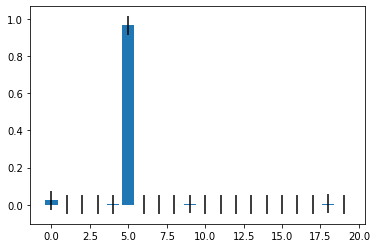

In [ ]:
plt.figure()
plt.bar(np.arange(train_dataset.num_classes), pred_distribution[idx].squeeze(), yerr=var[idx].squeeze())
plt.show()

In [ ]:
train_dataset.categories[pred[idx].item()], train_dataset.categories[example_targets[idx].item()]

('forest', 'forest')

In [ ]:
pred_distribution[idx]

array([3.84902090e-01, 4.22527641e-02, 1.21948351e-05, 1.30574870e-06,
       5.65320134e-01, 6.22384017e-03, 1.77999500e-08, 3.14467965e-04,
       2.80171989e-05, 2.03644260e-04, 1.29229811e-05, 1.67012422e-05,
       7.25710288e-06, 3.94964536e-06, 1.16276322e-04, 2.84280958e-07,
       1.32170753e-05, 1.35126365e-05, 5.50360652e-04, 7.04955664e-06],
      dtype=float32)

In [ ]:
var

array([0.04763656, 0.02717953, 0.04235103, 0.0226156 , 0.03330511,
       0.03051318, 0.0167819 , 0.02344266, 0.02349811, 0.04508165],
      dtype=float32)